In [1]:

!pip install numpy nibabel matplotlib scipy scikit-image tqdm SimpleITK PyWavelets




In [2]:
!git clone https://github.com/MIC-DKFZ/HD-BET.git

Cloning into 'HD-BET'...


In [3]:
%cd HD-BET

c:\Users\HP\Downloads\HD-BET


In [4]:
!pip install -e .

Obtaining file:///C:/Users/HP/Downloads/HD-BET
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Building editable for HD_BET (pyproject.toml): started
  Building editable for HD_BET (pyproject.toml): finished with status 'done'
  Created wheel for HD_BET: filename=hd_bet-2.0.1-0.editable-py3-none-any.whl size=10104 sha256=8f35bd9319051427f5d7207667b6fdd98aa8835be0948b1b5f9a0984860cce15
  Stored in directory: C:\Users\HP\A

In [5]:
!hd-bet -h


########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

usage: hd-bet [-h] -i INPUT [-o OUTPUT] [-device DEVICE] [--disable_tta]
              [--save_bet_mask] [--no_bet_image] [--verbose]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        input. Can be either a single file name or an input
                        folder. If file: must be nifti (.nii.gz) and can only
                        

In [6]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, rotate
import SimpleITK as sitk
from skimage.restoration import denoise_nl_means, estimate_sigma
from tqdm import tqdm
import subprocess
import tempfile
import torch

In [7]:
input_root = r"C:\Users\HP\Downloads\ADNI"
output_root = r"C:\Users\HP\Downloads\Preprocessed_ADNI_flat"
target_shape = (128, 128, 128)

In [8]:
def show_comparison(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(6 * len(images), 6))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def normalize(image):
    print("  Normalizing...")
    image = image.astype(np.float32)
    image -= np.min(image)
    if np.max(image) > 0:
        image /= np.max(image)
    return image

In [9]:
def skull_strip(image, affine):
    print(" Skull stripping (HD-BET)...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with tempfile.TemporaryDirectory() as tempdir:
        input_path = os.path.join(tempdir, "input.nii.gz")
        output_path = os.path.join(tempdir, "input_bet.nii.gz")
        nib.save(nib.Nifti1Image(image, affine), input_path)
        result = subprocess.run(
            ["hd-bet", "-i", input_path, "-o", output_path, "-device", device],
            capture_output=True, text=True, encoding='utf-8', errors='replace'
        )
        if result.returncode != 0:
            raise RuntimeError("HD-BET skull stripping failed:\n" + result.stderr)
        stripped_img = nib.load(output_path)
        return stripped_img.get_fdata()

def bias_correction(image):
    print(" Bias field correction (N4)...")
    sitk_img = sitk.GetImageFromArray(image)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = corrector.Execute(sitk_img)
    return sitk.GetArrayFromImage(corrected)


In [11]:
def resize(image, target_shape):
    print(f" Resizing to {target_shape}...")
    zoom_factors = [t / s for t, s in zip(target_shape, image.shape)]
    return zoom(image, zoom_factors, order=1)

def denoise(image):
    print(" Denoising (Non-local Means)...")
    try:
        sigma = estimate_sigma(image, channel_axis=None)
        return denoise_nl_means(image, h=1.15 * sigma, fast_mode=True,
                                patch_size=5, patch_distance=3, channel_axis=None)
    except ImportError:
        return image

def register_to_template(image):
    print("Registration step (placeholder)...")
    return image

def augment(image):
    print("Augmenting image (rotation)...")
    return rotate(image, angle=15, axes=(0, 1), reshape=False)

In [15]:
def preprocess_nifti_file(input_path, output_filename, visualize=False):
    try:
        print(f"\nProcessing: {input_path}")
        img = nib.load(input_path)
        data = img.get_fdata()
        affine = img.affine
        visuals, titles = [], []

        if visualize:
            axial = data[data.shape[0] // 2, :, :]
            coronal = data[:, data.shape[1] // 2, :]
            sagittal = data[:, :, data.shape[2] // 2]
            visuals.extend([axial, coronal, sagittal])
            titles.extend(["Axial", "Coronal", "Sagittal"])

        steps = [
            ("Normalize", normalize),
            ("Skull Strip", lambda x: skull_strip(x, affine)),
            ("Bias Correction", bias_correction),
            ("Resize", lambda x: resize(x, target_shape)),
            ("Denoise", denoise),
            ("Register", register_to_template),
        ]

        for label, func in tqdm(steps, desc="Preprocessing Steps", leave=False):
            print(f"   Running: {label}")
            data = func(data)
            if visualize:
                sagittal = data[data.shape[0] // 2, :, :]
                coronal = data[:, data.shape[1] // 2, :]
                axial = data[:, :, data.shape[2] // 2]
                visuals.extend([sagittal, coronal, axial])
                titles.extend([f"{label} (Axial)", f"{label} (Coronal)", f"{label} (Sagittal)"])

        final_img = nib.Nifti1Image(data, affine)
        os.makedirs(output_root, exist_ok=True)
        output_path = os.path.join(output_root, output_filename)
        nib.save(final_img, output_path)
        print(f"Saved: {output_path}")

        if visualize:
            show_comparison(visuals, titles)

    except Exception as e:
        print(f"Error processing {input_path}: {e}")

Preprocessing All MRI Scans:   0%|          | 0/230 [00:00<?, ?it/s]


Processing: C:\Users\HP\Downloads\ADNI\002_S_0295\MPR__GradWarp__B1_Correction__N3__Scaled\2006-11-02_08_16_44.0\I40966\ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070219173850420_S21856_I40966.nii


   Running: Normalize
  Normalizing...
   Running: Skull Strip
 Skull stripping (HD-BET)...


   Running: Bias Correction
 Bias field correction (N4)...


   Running: Resize
 Resizing to (128, 128, 128)...


   Running: Denoise
 Denoising (Non-local Means)...


   Running: Register
Registration step (placeholder)...
Saved: C:\Users\HP\Downloads\Preprocessed_ADNI_flat\002_S_0295_MPR__GradWarp__B1_Correction__N3__Scaled_2006-11-02_08_16_44.0_I40966ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070219173850420_S21856_I40966.nii


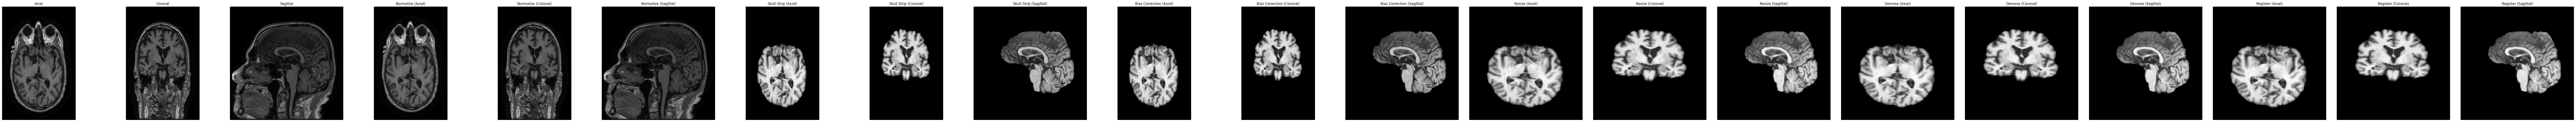

Preprocessing All MRI Scans:   0%|          | 1/230 [05:02<19:14:23, 302.46s/it]


Processing: C:\Users\HP\Downloads\ADNI\002_S_0413\MPR__GradWarp__B1_Correction__N3__Scaled\2007-06-01_07_04_09.0\I60008\ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070713121420365_S32938_I60008.nii


   Running: Normalize
  Normalizing...
   Running: Skull Strip
 Skull stripping (HD-BET)...


   Running: Bias Correction
 Bias field correction (N4)...


   Running: Resize
 Resizing to (128, 128, 128)...


   Running: Denoise
 Denoising (Non-local Means)...


Preprocessing All MRI Scans:   1%|          | 2/230 [09:46<18:27:35, 291.47s/it]

   Running: Register
Registration step (placeholder)...
Saved: C:\Users\HP\Downloads\Preprocessed_ADNI_flat\002_S_0413_MPR__GradWarp__B1_Correction__N3__Scaled_2007-06-01_07_04_09.0_I60008ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070713121420365_S32938_I60008.nii

Processing: C:\Users\HP\Downloads\ADNI\002_S_0413\MPR__GradWarp__B1_Correction__N3__Scaled_2\2006-11-15_09_30_01.0\I118695\ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001120813046_S22557_I118695.nii


   Running: Normalize
  Normalizing...
   Running: Skull Strip
 Skull stripping (HD-BET)...


   Running: Bias Correction
 Bias field correction (N4)...


   Running: Resize
 Resizing to (128, 128, 128)...


   Running: Denoise
 Denoising (Non-local Means)...


Preprocessing All MRI Scans:   1%|▏         | 3/230 [13:40<16:43:47, 265.32s/it]

   Running: Register
Registration step (placeholder)...
Saved: C:\Users\HP\Downloads\Preprocessed_ADNI_flat\002_S_0413_MPR__GradWarp__B1_Correction__N3__Scaled_2_2006-11-15_09_30_01.0_I118695ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001120813046_S22557_I118695.nii

Processing: C:\Users\HP\Downloads\ADNI\002_S_0729\MPR__GradWarp__B1_Correction__N3__Scaled_2\2006-07-17_13_27_14.0\I118682\ADNI_002_S_0729_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115616920_S16874_I118682.nii


   Running: Normalize
  Normalizing...
   Running: Skull Strip
 Skull stripping (HD-BET)...


   Running: Bias Correction
 Bias field correction (N4)...


   Running: Resize
 Resizing to (128, 128, 128)...
   Running: Denoise
 Denoising (Non-local Means)...


Preprocessing All MRI Scans:   2%|▏         | 4/230 [17:16<15:26:14, 245.90s/it]

   Running: Register
Registration step (placeholder)...
Saved: C:\Users\HP\Downloads\Preprocessed_ADNI_flat\002_S_0729_MPR__GradWarp__B1_Correction__N3__Scaled_2_2006-07-17_13_27_14.0_I118682ADNI_002_S_0729_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115616920_S16874_I118682.nii

Processing: C:\Users\HP\Downloads\ADNI\002_S_1018\MPR__GradWarp__B1_Correction__N3__Scaled\2007-07-16_06_56_24.0\I73016\ADNI_002_S_1018_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070913150134327_S35097_I73016.nii


   Running: Normalize
  Normalizing...
   Running: Skull Strip
 Skull stripping (HD-BET)...


In [ ]:
all_files = []

for root, _, files in os.walk(input_root):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            input_path = os.path.join(root, file)
            unique_id = "_".join(root.split(os.sep)[-4:])
            output_filename = f"{unique_id}{file}".replace(" ", "")
            all_files.append((input_path, output_filename))

processed = 0

for i, (input_path, output_filename) in enumerate(tqdm(all_files, desc="Preprocessing All MRI Scans")):
    preprocess_nifti_file(input_path, output_filename, visualize=(i == 0))
    processed += 1

print(f"Done. Total preprocessed files: {processed}")
